# Turing Target Practice

## Model

In [1]:
] activate "."

In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.1, 0.5)
    σ8 ~ Uniform(0.5, 10.1)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(spl, target, 20000;
                       monitor_energy=true, 
                       dialog=true,
                       initial_x = [0.2360, 0.8684])

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: NaN
eps: 0.125 --> VarE: 68611.86158040773
eps: 0.0625 --> VarE: 34194.21402321975
eps: 0.03125 --> VarE: 16593.51665854257
eps: 0.015625 --> VarE: 7703.244580494638
eps: 0.0078125 --> VarE: 3236.9198792133648
eps: 0.00390625 --> VarE: 999.2279353330802
eps: 0.001953125 --> VarE: 102.69961539122927
eps: 0.0009765625 --> VarE: 2.6891860832084484


[ Info: Tuning L ⏳


samples: 100--> ESS: 0.012728200479996331
samples: 243--> ESS: 0.005020878297933589
samples: 447--> ESS: 0.002681867321618315
samples: 739--> ESS: 0.002277313601289956
samples: 1157--> ESS: 0.0021890814088794544
samples: 1755--> ESS: 0.0021260002159309947
samples: 2610--> ESS: 0.002085432580130356
samples: 3833--> ESS: 0.002057284642741013
samples: 5581--> ESS: 0.0020396196821974044


[ Info: Found L: 1.4142135623730951 ✅


20001-element Vector{Any}:
 [0.3234910711830705, 7.262361557602668, 0.0, -16605.662065187425]
 [0.3234910711830705, 7.262361557602668, 0.37429956531559583, -16601.417375992103]
 [0.3235099232167945, 7.261463370009162, 9.731215316580347, -16596.298242963367]
 [0.32350123221135063, 7.260503117758479, 15.349497303810494, -16591.178788567275]
 [0.32349229297436455, 7.259543614188519, 15.357133384415647, -16586.059157552936]
 [0.32348311182266276, 7.258584862317573, 15.357811019803194, -16580.939422150386]
 [0.32347416029417875, 7.257625029476922, 15.357269108288165, -16575.81954652792]
 [0.32346520147729146, 7.2566650364326675, 15.355913020943262, -16570.699594195285]
 [0.3234563609282669, 7.255704403898322, 15.35617994335189, -16565.579451611313]
 [0.32344706619787833, 7.254745350711365, 15.358185452791076, -16560.45918490686]
 [0.3234377542524465, 7.253786178793675, 15.359378276007192, -16555.338752399126]
 [0.32342854856979414, 7.252826396664132, 15.360952566694323, -16550.218185772657]

In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

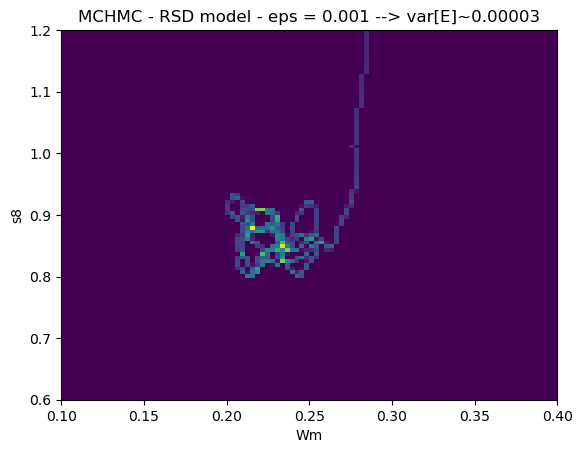

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [12]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: NaN
eps: 0.125 --> VarE: 119933.92318887921
eps: 0.0625 --> VarE: 58766.619063702405
eps: 0.03125 --> VarE: 27878.24787153446
eps: 0.015625 --> VarE: 12372.444959427163
eps: 0.0078125 --> VarE: 4605.866142124574
eps: 0.00390625 --> VarE: 785.3154256782931
eps: 0.001953125 --> VarE: 12.394882266917906
eps: 0.0009765625 --> VarE: 3.325926054572447
samples: 100--> ESS: 0.012726936710868279
samples: 243--> ESS: 0.005020935083480868
samples: 447--> ESS: 0.002682146465327753
samples: 739--> ESS: 0.002277905884410017


[ Info: Tuning L ⏳


samples: 1157--> ESS: 0.0021901162276408994
samples: 1755--> ESS: 0.0021276300292069877
samples: 2610--> ESS: 0.0020877416501127585
samples: 3833--> ESS: 0.0020598897714137034
samples: 5581--> ESS: 0.0020412187003093106


[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 4.05 seconds
Compute duration  = 4.05 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.3083    0.0189     0.0002    0.0019   20.3166    2.2922      ⋯
          σ8    4.4713    2.5896     0.0259    0.2602   20.1746    2.9169      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2794    0.2934    0.3055    0.3217    0.3471
          σ8    1.0543    1.9662    4.1248    6.9349    8.7090


In [13]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.26 seconds
Compute duration  = 1.26 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.3082    0.0188     0.0002    0.0019   20.3011    2.3053      ⋯
          σ8    4.4715    2.5896     0.0259    0.2602   20.1747    2.9168      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2804    0.2933    0.3054    0.3216    0.3470
          σ8    1.0536    1.9662    4.1249    6.9350    8.7091


In [14]:
#StatsPlots.plot(new_samples)

## NUTS

In [15]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.025
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   4%|█▋                                       |  ETA: 0:00:03┌ Warning: The current proposal will be rej

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 6.98 seconds
Compute duration  = 6.98 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2356    0.0675     0.0007    0.0012   2688.1702    1.0002    ⋯
          σ8    0.8688    0.0645     0.0006    0.0012   2464.4062    1.0011    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [16]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.164146  0.866072  10.7205  3.0  1.0  …  2.0  0.0  0.518996  0.518996
 0.171257  0.886016  11.7714  7.0  1.0     3.0  0.0  0.518996  0.518996
 0.201927  0.892377  12.6055  7.0  1.0     3.0  0.0  0.518996  0.518996
 0.20791   0.884927  12.6439  3.0  1.0     2.0  0.0  0.518996  0.518996
 0.181269  0.84689   11.0785  3.0  1.0     2.0  0.0  0.518996  0.518996
 0.208546  0.880929  12.6449  5.0  1.0  …  2.0  0.0  0.518996  0.518996
 0.237731  0.864187  12.6422  7.0  1.0     2.0  0.0  0.518996  0.518996
 0.315184  0.847738  11.3332  7.0  1.0     2.0  0.0  0.518996  0.518996
 0.315184  0.847738  11.3332  3.0  1.0     1.0  0.0  0.518996  

In [17]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

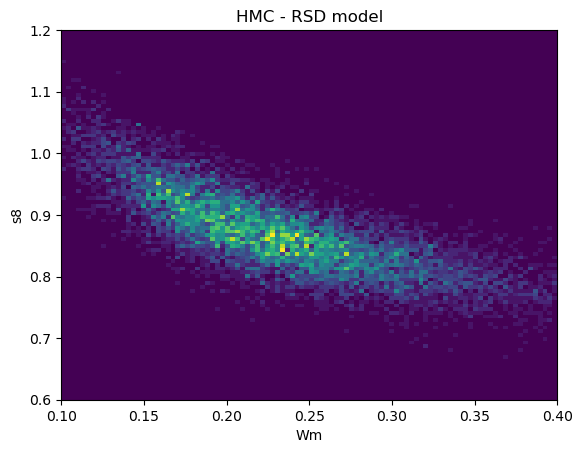

In [18]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");